In [29]:
import numpy as np
import tensorflow as tf
import deepxde as dde
import geopandas as gpd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm, lognorm
import xarray as xr
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import requests
from bs4 import BeautifulSoup
import pandas as pd


In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
DATA_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/"
INPUT_MODEL_PATH = DATA_PATH + "processed_data/"
MODEL_SAVE_PATH = DATA_PATH + "trained_models/"
RESULTS_PATH = DATA_PATH + "model_results/"

In [32]:
with open("functions_training_model.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)

In [33]:
df_empirical_Holocene = pd.read_csv(INPUT_MODEL_PATH + "df_empirical_Holocene.csv")

df_global_grid = pd.read_csv(INPUT_MODEL_PATH + "df_global_grid.csv")
df_wind = pd.read_csv(INPUT_MODEL_PATH + "df_wind.csv", usecols=['wind', 'latitude'])
latitude_wind, mean_wind = df_wind['latitude'].values/90, df_wind['wind'].values/df_wind['wind'].max()

def wind_latitude(latitude):
    interpolated = wind_tf_interp(latitude, tf.convert_to_tensor(latitude_wind), tf.convert_to_tensor(mean_wind))
    return interpolated

tf_wind_latitude = tf.function(wind_latitude)

In [34]:

def training_points(df):

    data_observ_points = dde.data.DataSet(
        X_train = df[['lon', 'lat']].values/90,
        y_train = df['log_dep_norm'].values.reshape(-1,1),
        X_test = df[['lon', 'lat']].values/90,
        y_test = df['log_dep_norm'].values.reshape(-1,1),
        standardize=False)

    observe_u  = dde.icbc.PointSetBC(data_observ_points.train_x,
        df['log_dep_norm'].values.reshape(-1,1), component=0)

    return data_observ_points, observe_u


In [35]:
x_min, x_max = -2.0, 2.0
y_min, y_max = -0.89, 0.89

left_corner = np.array([x_min, y_min])  # xmin, ymin – Coordinate of bottom left corner.
right_corner = np.array([x_max, y_max])  # xmax, ymax – Coordinate of top right corner.
geometry_rectangle = dde.geometry.geometry_2d.Rectangle(left_corner, right_corner)

# Reduce the training domain to avoid pole singularities.
df_empirical_Holocene_2 = df_empirical_Holocene[
    (df_empirical_Holocene['lat'] >= -81) & (df_empirical_Holocene['lat'] <= 81)]
#df_simulated_LGM_2 = df_simulated_LGM[(df_simulated_LGM['lat'] >= -81) & (df_simulated_LGM['lat'] <= 81)]

In [36]:

def pde(x, u):
    du_x = dde.grad.jacobian(u, x, j=0)  # du/dlambda
    du_y = dde.grad.jacobian(u, x, j=1)  # du/dtheta

    K = wind_latitude(x[:, 1:2])
    K = tf.cast(K, tf.float32)

    du_xx = dde.grad.hessian(u, x, i=0, j=0)  # d^2u/dlambda^2
    du_yy = dde.grad.hessian(u, x, i=1, j=1)  # d^2u/dtheta^2

    return (
        (-K * du_x * (1 / tf.cos(x[:, 1:2] * np.pi / 2)) +
         D * ((1 / (tf.cos(x[:, 1:2] * np.pi / 2) ** 2) * du_xx + du_yy - tf.tan(x[:, 1:2] * np.pi / 2) * du_y)))
    )

In [37]:
def space_boundary_north(x, on_boundary):
    return on_boundary and np.isclose(y_max, x[1])


def space_boundary_south(x, on_boundary):
    return on_boundary and np.isclose(y_min, x[1])


def periodic_boundary(x, domain):
    return domain and (np.isclose(x[0], x_min) or np.isclose(x[0], x_max))

In [38]:
def mse_metric(y_true, y_pred):
    if y_true is None or y_pred is None:
        return tf.constant(0.0)
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [39]:
import os

def train_process(data_observ_points, observe_u, D, bc_1, bc_2, model_name):
 # Percorso cartella per salvataggio modelli e variabili
    save_dir = MODEL_SAVE_PATH + model_name + "/"

    # Crea la cartella se non esiste
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    data = dde.data.PDE(
        geometry_rectangle,
        pde,
        [observe_u, periodic_condition, periodic_condition_derivative, bc_1, bc_2],
        num_domain=2592,
        num_boundary=216,
        anchors=data_observ_points.train_x,
        train_distribution='uniform'
    )

    neurons = 32
    layer = 5
    layer_size = [2] + [neurons] * layer + [1]
    activation = "selu"
    initializer = "Glorot normal"
    net = dde.maps.FNN(layer_size, activation, initializer)
    model = dde.Model(data, net)
    dde.optimizers.set_LBFGS_options(maxcor=50, ftol=1e-20, maxiter=1e5)
    model.compile("adam", lr=0.00001, external_trainable_variables=[D, north_mean, south_mean],
                  loss_weights=[1, 10, 0.5, 0.5, 1, 1] )

    # Train and save the model


    checkpointer = dde.callbacks.ModelCheckpoint(
        f"{MODEL_SAVE_PATH}{model_name}/{model_name}.ckpt",
        verbose=0, period=10000,
    )

    variable = dde.callbacks.VariableValue([D, north_mean, south_mean], period=10000,
                                           filename=MODEL_SAVE_PATH + model_name + "/variables.dat")

    losshistory, train_state = model.train(epochs=1000, callbacks=[variable, checkpointer])
    dde.saveplot(losshistory, train_state, issave=False, isplot=True)
    params = variable.get_value()

    return model, params, train_state.best_step

In [40]:
north_mean = dde.Variable(-1.0)
south_mean = dde.Variable(-2.0)
D = dde.Variable(1.0)

bc_1 = dde.DirichletBC(geometry_rectangle, lambda x: north_mean, space_boundary_north)
bc_2 = dde.DirichletBC(geometry_rectangle, lambda x: south_mean, space_boundary_south)
periodic_condition = dde.icbc.PeriodicBC(geom=geometry_rectangle, component_x=0, on_boundary=periodic_boundary,
                                         derivative_order=0)
periodic_condition_derivative = dde.icbc.PeriodicBC(geom=geometry_rectangle, component_x=0,
                                                    on_boundary=periodic_boundary, derivative_order=1)


📂 Fold 1/5...
Compiling model...
Building feed-forward neural network...
'build' took 0.192284 s

'compile' took 1.651135 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.71e+01, 1.25e+01, 1.29e-01, 7.29e-03, 8.56e-01, 4.77e+00]    [2.71e+01, 1.25e+01, 1.29e-01, 7.29e-03, 8.56e-01, 4.77e+00]    []  
1000      [2.29e+00, 7.12e+00, 2.49e-01, 9.05e-03, 1.47e+00, 1.91e+00]    [2.29e+00, 7.12e+00, 2.49e-01, 9.05e-03, 1.47e+00, 1.91e+00]    []  

Best model at step 1000:
  train loss: 1.30e+01
  test loss: 1.30e+01
  test metric: []

'train' took 38.986321 s



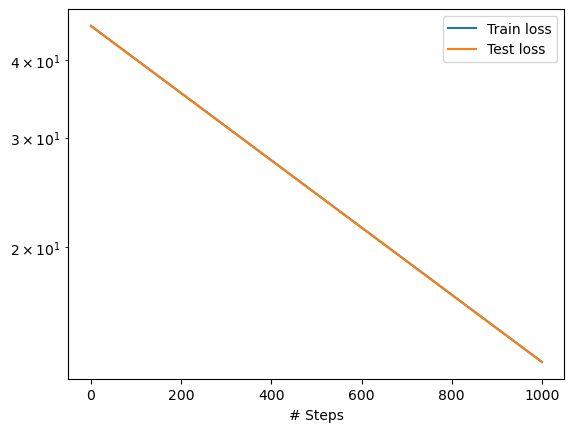

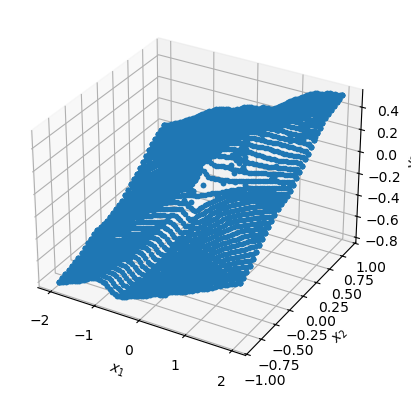

✅ Fold 1 - Test MSE: 0.6779 - Training MSE: 0.7120
✅ Fold 1 - PINN Test MSE: 0.6779 - PINN Train MSE: 0.7120 - Kriging Test MSE: 0.3910

📂 Fold 2/5...
Compiling model...
Building feed-forward neural network...
'build' took 0.095900 s

'compile' took 2.106888 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.76e+01, 1.22e+01, 1.29e-01, 7.29e-03, 8.56e-01, 4.77e+00]    [2.76e+01, 1.22e+01, 1.29e-01, 7.29e-03, 8.56e-01, 4.77e+00]    []  
1000      [2.22e+00, 6.73e+00, 2.87e-01, 8.46e-03, 1.44e+00, 1.96e+00]    [2.22e+00, 6.73e+00, 2.87e-01, 8.46e-03, 1.44e+00, 1.96e+00]    []  

Best model at step 1000:
  train loss: 1.27e+01
  test loss: 1.27e+01
  test metric: []

'train' took 62.993318 s



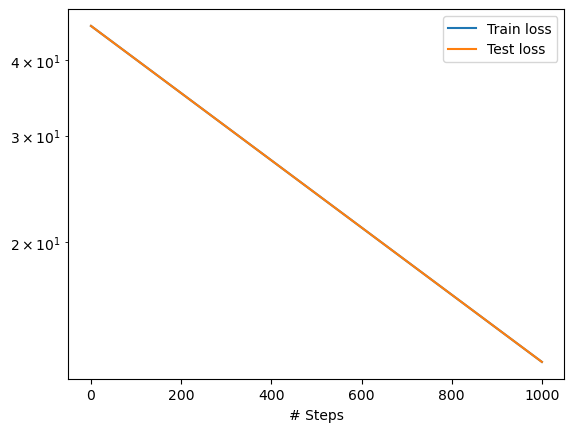

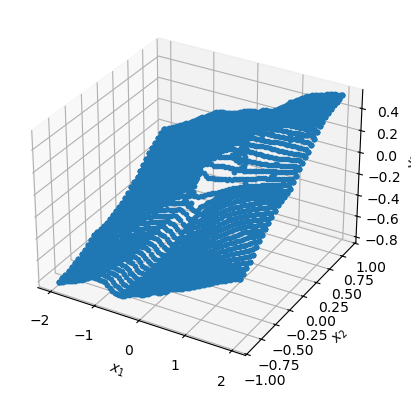

✅ Fold 2 - Test MSE: 0.8358 - Training MSE: 0.6732
✅ Fold 2 - PINN Test MSE: 0.8358 - PINN Train MSE: 0.6732 - Kriging Test MSE: 0.3013

📂 Fold 3/5...
Compiling model...
Building feed-forward neural network...
'build' took 0.351558 s

'compile' took 5.015137 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.75e+01, 1.27e+01, 1.29e-01, 7.29e-03, 8.56e-01, 4.77e+00]    [2.75e+01, 1.27e+01, 1.29e-01, 7.29e-03, 8.56e-01, 4.77e+00]    []  
1000      [2.22e+00, 7.12e+00, 2.58e-01, 8.78e-03, 1.43e+00, 1.86e+00]    [2.22e+00, 7.12e+00, 2.58e-01, 8.78e-03, 1.43e+00, 1.86e+00]    []  

Best model at step 1000:
  train loss: 1.29e+01
  test loss: 1.29e+01
  test metric: []

'train' took 85.345629 s



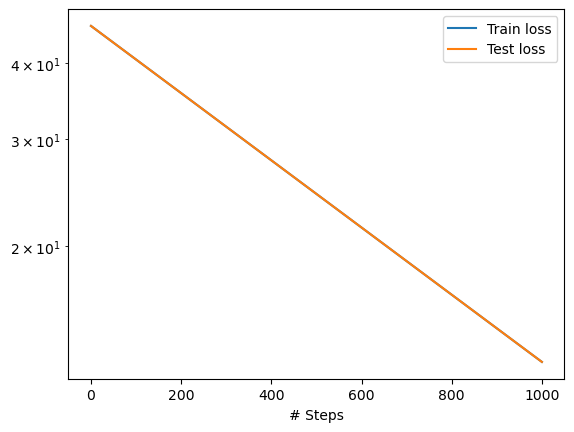

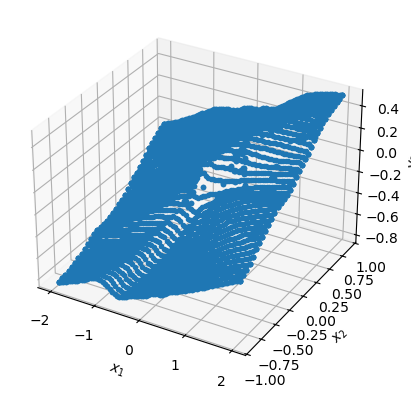

✅ Fold 3 - Test MSE: 0.6965 - Training MSE: 0.7121
✅ Fold 3 - PINN Test MSE: 0.6965 - PINN Train MSE: 0.7121 - Kriging Test MSE: 0.3028

📂 Fold 4/5...
Compiling model...
Building feed-forward neural network...
'build' took 0.449573 s

'compile' took 4.806973 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.75e+01, 1.32e+01, 1.29e-01, 7.29e-03, 8.56e-01, 4.77e+00]    [2.75e+01, 1.32e+01, 1.29e-01, 7.29e-03, 8.56e-01, 4.77e+00]    []  
1000      [2.33e+00, 7.36e+00, 2.52e-01, 8.91e-03, 1.47e+00, 1.82e+00]    [2.33e+00, 7.36e+00, 2.52e-01, 8.91e-03, 1.47e+00, 1.82e+00]    []  

Best model at step 1000:
  train loss: 1.32e+01
  test loss: 1.32e+01
  test metric: []

'train' took 70.513110 s



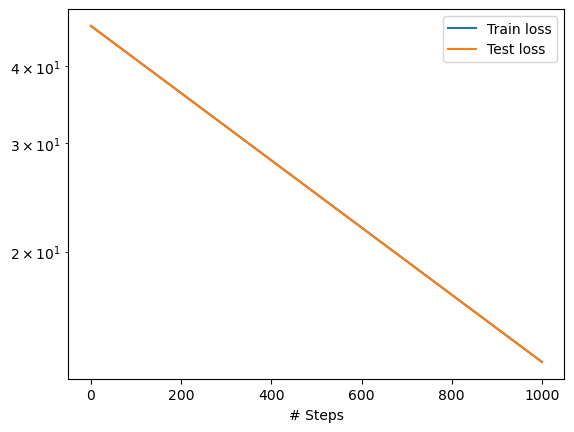

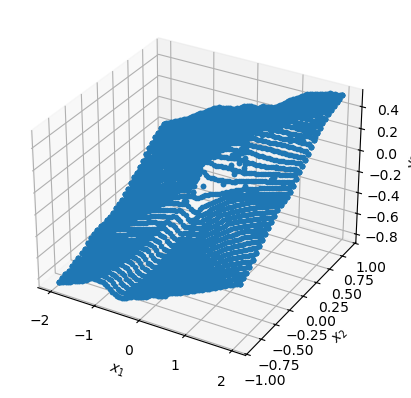

✅ Fold 4 - Test MSE: 0.5733 - Training MSE: 0.7357
✅ Fold 4 - PINN Test MSE: 0.5733 - PINN Train MSE: 0.7357 - Kriging Test MSE: 0.2207

📂 Fold 5/5...
Compiling model...
Building feed-forward neural network...
'build' took 0.136545 s

'compile' took 2.088431 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.75e+01, 1.20e+01, 1.29e-01, 7.29e-03, 8.56e-01, 4.77e+00]    [2.75e+01, 1.20e+01, 1.29e-01, 7.29e-03, 8.56e-01, 4.77e+00]    []  
1000      [2.24e+00, 6.93e+00, 2.37e-01, 8.78e-03, 1.46e+00, 1.92e+00]    [2.24e+00, 6.93e+00, 2.37e-01, 8.78e-03, 1.46e+00, 1.92e+00]    []  

Best model at step 1000:
  train loss: 1.28e+01
  test loss: 1.28e+01
  test metric: []

'train' took 65.617261 s



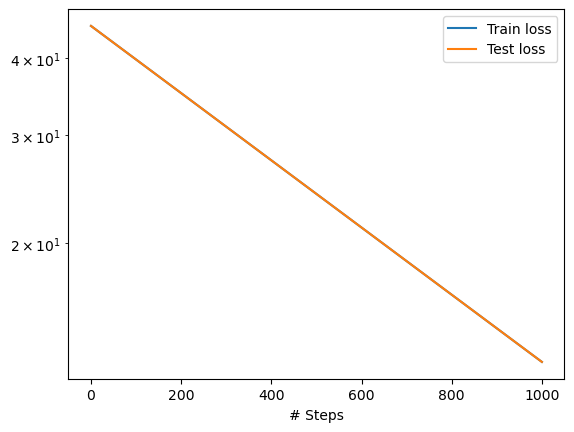

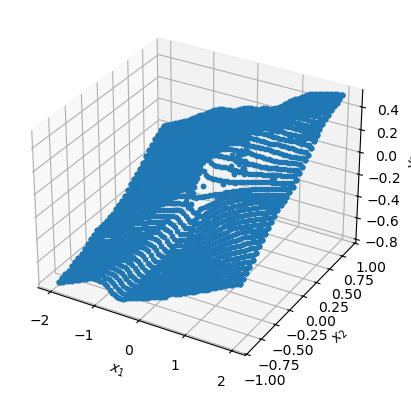

✅ Fold 5 - Test MSE: 0.7642 - Training MSE: 0.6934
✅ Fold 5 - PINN Test MSE: 0.7642 - PINN Train MSE: 0.6934 - Kriging Test MSE: 0.3661


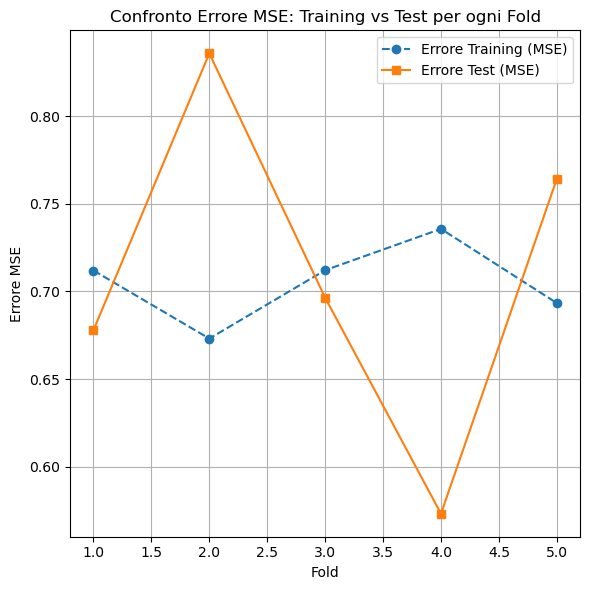

In [41]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
# Definisci il numero di fold
n_splits = 5  # Modifica questo valore a seconda di quante suddivisioni vuoi

# Crea il KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# Crea le liste per raccogliere i MSE di training e test
train_mses = []  # Lista per i MSE di training
test_mses = []   # Lista per i MSE di test


fold = 1
for train_index, test_index in kf.split(df_empirical_Holocene_2):
    print(f"\n📂 Fold {fold}/{n_splits}...")

    # Preparazione train/test
    df_train = df_empirical_Holocene_2.iloc[train_index]
    df_test = df_empirical_Holocene_2.iloc[test_index]

    # Definisci i dati di addestramento (data_observ_points_train) usando df_train
    data_observ_points_train, observe_u_train = training_points(df_train)

    # Addestra il modello PINN
    model_empirical_Holocene, params, best_step = train_process(
        data_observ_points_train,
        observe_u_train,
        D,
        bc_1,
        bc_2,
        f"model_empirical_Holocene_fold{fold}"
    )

    # MSE di training
    X_train = df_train[['lon', 'lat']].values / 90
    X_test = df_test[['lon', 'lat']].values / 90
    y_train = df_train['log_dep_norm'].values.reshape(-1, 1)
    y_train_pred = model_empirical_Holocene.predict(X_train)
    mse_train = np.mean((y_train_pred - y_train)**2)
    train_mses.append(mse_train)

    # MSE di test
    y_pred = model_empirical_Holocene.predict(df_test[['lon', 'lat']].values / 90)
    y_test = df_test['log_dep_norm'].values.reshape(-1, 1)
    test_mse = np.mean((y_pred - y_test)**2)
    test_mses.append(test_mse)


    print(f"✅ Fold {fold} - Test MSE: {test_mse:.4f} - Training MSE: {mse_train:.4f}")
    lons_train = df_train['lon'].values
    lats_train = df_train['lat'].values
    values_train = df_train['log_dep'].values  # o 'log_dep_norm' se preferisci

    # Fitting kriging modello
    OK = OrdinaryKriging(
        lons_train, lats_train, values_train,
        variogram_model='spherical',
        verbose=False,
        enable_plotting=False,
        pseudo_inv=True

    )
     # Predizione kriging su test set punti (coordinate test)
    z_krig_test, ss_krig_test = OK.execute('points', df_test['lon'].values, df_test['lat'].values)

    # Calcola MSE kriging sul test
    mse_krig_test = np.mean((z_krig_test - df_test['log_dep'].values) ** 2)

    print(f"✅ Fold {fold} - PINN Test MSE: {test_mse:.4f} - PINN Train MSE: {mse_train:.4f} - Kriging Test MSE: {mse_krig_test:.4f}")

    fold += 1

# Ora fold, train_mses e test_mses dovrebbero avere la stessa lunghezza
folds = list(range(1, n_splits + 1))

# Grafico
plt.figure(figsize=(6, 6))
plt.plot(folds, train_mses, label='Errore Training (MSE)', marker='o', linestyle='--')
plt.plot(folds, test_mses, label='Errore Test (MSE)', marker='s', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('Errore MSE')
plt.title('Confronto Errore MSE: Training vs Test per ogni Fold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}train_vs_test_mse_folds.png")
plt.show()


In [42]:
def calculate_save_df(model, df_to_predict, mean, std, path, filename):
    "Perform the predictions and save the results."
    U_pred = model.predict(df_to_predict[['lon', 'lat']].values/90)
    U_pred_denorm = (U_pred + mean)*std
    df_to_predict['PINN_log_dep'] = U_pred_denorm

    with open(path + filename, 'w') as f:
        df_to_predict.to_csv(f, index=False)

In [43]:
mean = df_empirical_Holocene['log_dep'].mean()
std = df_empirical_Holocene['log_dep'].std()

# PINN reconstruction on the global grid
calculate_save_df(model_empirical_Holocene, df_global_grid, mean, std, RESULTS_PATH, "df_pinn_empirical_Holocene_global_grid.csv")

# PINN reconstruction in the training locations
calculate_save_df(model_empirical_Holocene, df_empirical_Holocene, mean, std, RESULTS_PATH, "df_pinn_empirical_Holocene_training_points.csv")